Using image: /home/zano/Documents/TESI/FOLDER_CINECA/data/4c_MIP/MSA/MAX_4092.lif - 4092 DL VIP red Sinapto gr TH b D grey 63x z 2 pinhole 1 z 05 gh.tif
Tifffile stats: shape=(4, 1024, 1024), dtype=uint8, range=[0, 255]

--- Cross-Verification with skimage ---
Skimage stats:  shape=(1024, 1024, 4), dtype=uint8, range=[0, 255]
SUCCESS: Both loaders yielded IDENTICAL raw pixel data.
Conclusion: The low intensity statistics are intrinsic to the data (sparse signal).
---------------------------------------

Detected uint8 image. Normalizing by 255.0
Raw tensor statistics (before any visualization stretch):


,channel,mean,std,min,max,p1,p50,p99
0,R,0.030882,0.068861,0.000000,1.000000,0.003922,0.015686,0.356863
1,G,0.009044,0.023139,0.000000,0.878431,0.000000,0.003922,0.113725
2,B,0.087122,0.070319,0.003922,1.000000,0.015686,0.074510,0.356863
3,Gray,0.063875,0.057490,0.000000,0.384314,0.007843,0.035294,0.219608


Saved stats to intensity_aug_outputs/original_raw_stats.csv


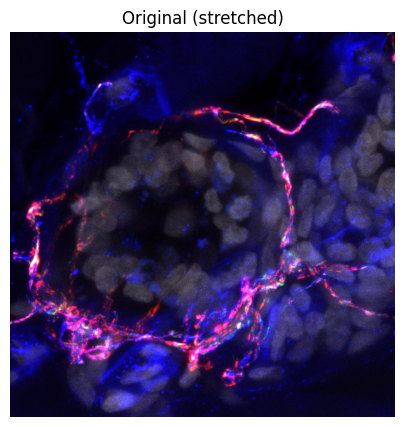

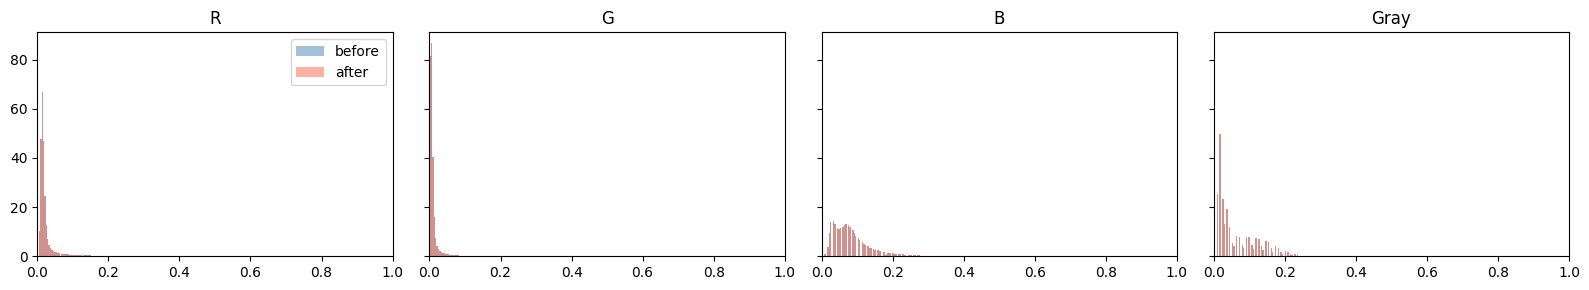

In [ ]:
import sys
from pathlib import Path
import numpy as np
import torch
import tifffile
import skimage.io  # Added for verification
import matplotlib.pyplot as plt
from IPython import get_ipython
from matplotlib_inline.backend_inline import set_matplotlib_formats
_ip = get_ipython()
if _ip is not None:
    _ip.run_line_magic("matplotlib", "inline")
    set_matplotlib_formats("png")
from IPython.display import display
import pandas as pd
from monai.transforms import (
    RandHistogramShiftd,
    RandAdjustContrastd,
    RandGaussianNoised,
    RandBiasFieldd,
    RandCoarseDropoutd,
)

# Reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Ensure project modules import
repo_root = Path(__file__).resolve().parents[1] if '__file__' in globals() else Path.cwd().parent
if str(repo_root) not in sys.path:
    sys.path.append(str(repo_root))

from utils.transformations_functions import (
    _poisson_gaussian_lambda,
    _weak_bleedthrough_lambda,
    from_GBR_to_RGB,
)

# Pick one 4-channel MSA image (fallback to MIP dir if needed)
data_dir = repo_root / 'data' / '4c' / 'MSA'
if not data_dir.exists():
    data_dir = repo_root / 'data' / '4c_MIP' / 'MSA'
img_paths = sorted(data_dir.glob('*.tif'))
if not img_paths:
    raise FileNotFoundError(f'No .tif files in {data_dir}')
img_path = img_paths[1]
print(f'Using image: {img_path}')

# Load image; if channel-last, move to channel-first
# CHANGE: Inspect raw dtype to determine correct normalization factor
img_raw = tifffile.imread(str(img_path))
print(f"Tifffile stats: shape={img_raw.shape}, dtype={img_raw.dtype}, range=[{img_raw.min()}, {img_raw.max()}]")

# --- VERIFICATION BLOCK START ---
# Professor Note: Cross-verifying with a different library (scikit-image) ensures 
# the low statistics are real and not a decoding error.
print("\n--- Cross-Verification with skimage ---")
try:
    img_check = skimage.io.imread(str(img_path))
    print(f"Skimage stats:  shape={img_check.shape}, dtype={img_check.dtype}, range=[{img_check.min()}, {img_check.max()}]")
    
    # Handle potential shape differences (skimage often loads TIFFs as HWC or CHW depending on metadata)
    if img_check.shape != img_raw.shape:
        # Attempt to align shapes for comparison (e.g. HWC -> CHW)
        if img_check.ndim == 3 and img_check.shape[-1] == img_raw.shape[0]:
            img_check = np.moveaxis(img_check, -1, 0)
            
    if np.array_equal(img_raw, img_check):
        print("SUCCESS: Both loaders yielded IDENTICAL raw pixel data.")
        print("Conclusion: The low intensity statistics are intrinsic to the data (sparse signal).")
    else:
        print("WARNING: Loaders yielded different data.")
except Exception as e:
    print(f"Skimage verification skipped: {e}")
print("---------------------------------------\n")
# --- VERIFICATION BLOCK END ---

img_np = img_raw.astype(np.float32)

# Normalize to [0, 1] based on bit-depth
# PROFESSOR NOTE:
# While [0, 1] is preferred for visualization and certain augmentations (like Gamma),
# raw inputs with mean ~0.01 will cause vanishing gradients in a CNN.
# IN TRAINING: You must apply Z-score normalization: (x - x.mean()) / x.std().
if img_np.max() > 1.0:
    if img_raw.dtype == np.uint16:
        print("Detected uint16 image. Normalizing by 65535.0")
        img_np = img_np / 65535.0
    elif img_raw.dtype == np.uint8:
        print("Detected uint8 image. Normalizing by 255.0")
        img_np = img_np / 255.0
    else:
        # Fallback for unknown types
        print(f"Detected {img_raw.dtype}. Normalizing by max value found: {img_np.max()}")
        img_np = img_np / img_np.max()

if img_np.ndim == 2:
    img_np = img_np[None, ...]
elif img_np.ndim == 3 and img_np.shape[0] not in (3, 4):
    img_np = np.moveaxis(img_np, -1, 0)
elif img_np.ndim != 3:
    raise ValueError(f'Unexpected image shape {img_np.shape}')

# Reorder channels to RGB + Gray (4th channel) as expected downstream
img = torch.from_numpy(img_np)
img = from_GBR_to_RGB(img)

before = img.clone()
H, W = img.shape[1:]
output_dir = Path('intensity_aug_outputs')
output_dir.mkdir(parents=True, exist_ok=True)

# Raw tensor statistics ----------------------------------------------------
def tensor_stats(t: torch.Tensor, name: str):
    """Compute per-channel and global stats on raw tensor (no stretching)."""
    t_np = t.cpu().numpy()
    ch_names = ['R', 'G', 'B', 'Gray'] if t_np.shape[0] == 4 else [f'Ch{i}' for i in range(t_np.shape[0])]
    rows = []
    for idx, ch in enumerate(ch_names):
        c = t_np[idx].ravel()
        rows.append({
            'channel': ch,
            'mean': float(c.mean()),
            'std': float(c.std()),
            'min': float(c.min()),
            'max': float(c.max()),
            'p1': float(np.percentile(c, 1)),
            'p50': float(np.percentile(c, 50)),
            'p99': float(np.percentile(c, 99)),
        })
    df = pd.DataFrame(rows)
    display(df)
    csv_path = output_dir / f'{name}_stats.csv'
    df.to_csv(csv_path, index=False)
    print(f'Saved stats to {csv_path}')

print('Raw tensor statistics (before any visualization stretch):')

tensor_stats(before, 'original_raw')

# Visualization helpers ----------------------------------------------------
def _stretch(img_np, lo=1.0, hi=99.0, gamma=1.2):
    """Percentile stretch + optional gamma to boost contrast."""
    lo_v = np.percentile(img_np, lo)
    hi_v = np.percentile(img_np, hi)
    img = np.clip((img_np - lo_v) / max(hi_v - lo_v, 1e-6), 0, 1)
    return np.power(img, gamma) if gamma != 1.0 else img

def _to_display(ch_first_np):
    """Convert C,H,W to RGB for plotting; 4th channel is gray overlay, not alpha."""
    if ch_first_np.shape[0] == 4:
        rgb = ch_first_np[:3].transpose(1, 2, 0)
        gray = ch_first_np[3][..., None]
        disp = np.clip(rgb + gray * 0.6, 0, 1)
    elif ch_first_np.shape[0] == 3:
        disp = ch_first_np.transpose(1, 2, 0)
    else:
        disp = np.repeat(ch_first_np[0:1].transpose(1, 2, 0), 3, axis=2)
    return _stretch(disp)

def show_side_by_side(before_t, after_t, title, fname):
    before_np = _to_display(before_t.cpu().numpy())
    after_np = _to_display(after_t.cpu().numpy())
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(before_np)
    axes[0].set_title('Original')
    axes[0].axis('off')
    axes[1].imshow(after_np)
    axes[1].set_title(title)
    axes[1].axis('off')
    plt.tight_layout()
    fig.savefig(output_dir / fname, dpi=200)
    display(fig)
    plt.close(fig)

def save_histogram(before_t, after_t, fname, bins=256, xlim=(0, 0.3), log=True):
    """Save and show channel-wise histograms before/after."""
    before_np = before_t.cpu().numpy()
    after_np = after_t.cpu().numpy()
    ch_names = ['R', 'G', 'B', 'Gray'] if before_np.shape[0] == 4 else [f'Ch{i}' for i in range(before_np.shape[0])]
    fig, axes = plt.subplots(1, len(ch_names), figsize=(4*len(ch_names), 3), sharey=True)
    if len(ch_names) == 1:
        axes = [axes]
    for idx, ax in enumerate(axes):
        b = before_np[idx].clip(0, 1).ravel()
        a = after_np[idx].clip(0, 1).ravel()
        ax.hist(b, bins=bins, range=(0,1), alpha=0.5, label='before', color='steelblue', density=True)
        ax.hist(a, bins=bins, range=(0,1), alpha=0.5, label='after', color='tomato', density=True)
        ax.set_title(ch_names[idx])
        if xlim:
            ax.set_xlim(*xlim)
        if log:
            ax.set_yscale('log')
    axes[0].legend()
    plt.tight_layout()
    fig.savefig(output_dir / fname, dpi=200)
    display(fig)
    plt.close(fig)

# Save the original once, stretched
orig_np = _to_display(before.numpy())
fig = plt.figure(figsize=(5,5))
plt.imshow(orig_np)
plt.title('Original (stretched)')
plt.axis('off')
fig.savefig(output_dir / 'original.png', dpi=200)
display(fig)
plt.close(fig)

# Save/show baseline histogram of the original
save_histogram(before, before, fname='original_hist.png', xlim=(0, 1), log=False)



In [15]:

# Define and apply intensity transforms (exaggerated for visualization)



In [16]:
# Load 3D volume from TIFF and basic stats
from pathlib import Path
from PIL import Image, ImageSequence
import numpy as np

tif_path = Path("../data/4092_gh.tif")
img = Image.open(tif_path)
frames = [np.array(f) for f in ImageSequence.Iterator(img)]
vol = np.stack(frames, axis=0)
Z, H, W = vol.shape
print(f"Volume shape: {vol.shape}, dtype: {vol.dtype}, min: {vol.min()}, max: {vol.max()}")
Z

Volume shape: (200, 1024, 1024), dtype: uint8, min: 0, max: 255


200

In [17]:
# Generate visualization panels and MIPs for DS1/DS2 explanation
import os
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

os.environ.setdefault("MPLCONFIGDIR", str(Path.cwd() / ".matplotlib"))
Path(os.environ["MPLCONFIGDIR"]).mkdir(exist_ok=True)

outdir = Path("images")
outdir.mkdir(exist_ok=True)

# 1) Grid of slices across Z
n_panels = 16
step = max(1, Z // n_panels)
sel = list(range(0, Z, step))[:n_panels]
cols = 4
rows = int(np.ceil(len(sel) / cols))
fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
for ax, z in zip(axes.flatten(), sel):
    ax.imshow(vol[z], cmap="gray")
    ax.set_title(f"z={z}")
    ax.axis("off")
for ax in axes.flatten()[len(sel):]:
    ax.axis("off")
fig.suptitle("4092_gh.tif slices across Z")
fig.tight_layout()
fig.savefig(outdir / "4092_gh_z_grid.png", dpi=200)
plt.close(fig)

# 2) Full MIP
mip_full = vol.max(axis=0)
plt.figure(figsize=(5, 5))
plt.imshow(mip_full, cmap="gray")
plt.title("Max intensity projection (all Z)")
plt.axis("off")
plt.tight_layout()
plt.savefig(outdir / "4092_gh_mip_full.png", dpi=200)
plt.close()

# 3) Block MIPs (quartiles)
blocks = np.array_split(np.arange(Z), 4)
fig, axes = plt.subplots(1, 4, figsize=(12, 3))
for ax, blk in zip(axes, blocks):
    mip = vol[blk].max(axis=0)
    ax.imshow(mip, cmap="gray")
    ax.set_title(f"z {blk[0]}-{blk[-1]}")
    ax.axis("off")
fig.suptitle("MIP by z-block (quartiles)")
fig.tight_layout()
fig.savefig(outdir / "4092_gh_mip_blocks.png", dpi=200)
plt.close(fig)

# 4) Central stack MIP (e.g., use as DS1 sub-stack)
win = min(50, Z)
start = (Z - win) // 2
end = start + win
mip_central = vol[start:end].max(axis=0)
plt.figure(figsize=(5, 5))
plt.imshow(mip_central, cmap="gray")
plt.title(f"MIP central {start}-{end-1} (win {win})")
plt.axis("off")
plt.tight_layout()
plt.savefig(outdir / "4092_gh_mip_central.png", dpi=200)
plt.close()

# 5) Simple z-profile (mean intensity per slice)
profile = vol.mean(axis=(1, 2))
plt.figure(figsize=(6, 3))
plt.plot(profile)
plt.xlabel("z slice")
plt.ylabel("mean intensity")
plt.title("Z intensity profile")
plt.tight_layout()
plt.savefig(outdir / "4092_gh_z_profile.png", dpi=200)
plt.close()

print("Saved outputs to", outdir)

Saved outputs to images


This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


Slide generated at: images/slide_subsection_mips.png


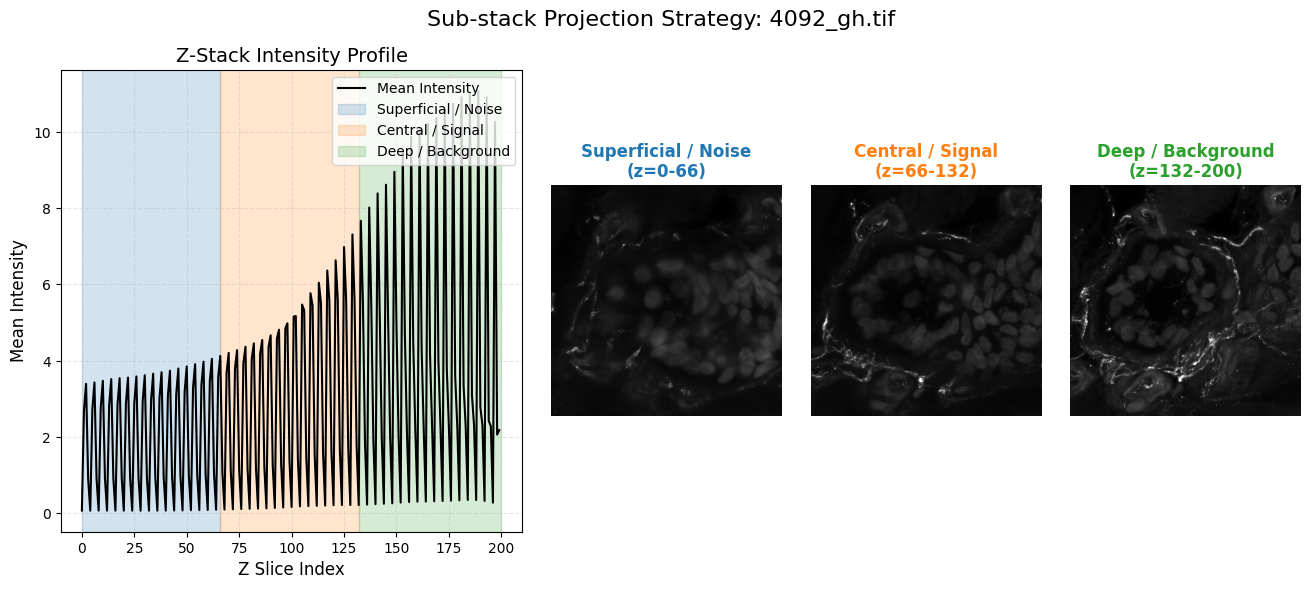

In [18]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
from pathlib import Path

# Ensure output directory exists
outdir = Path("images")
outdir.mkdir(exist_ok=True)

# 1. Calculate the Z-profile (mean intensity per slice)
# This serves as a quantitative guide for where the tissue is located.
profile = vol.mean(axis=(1, 2))
Z_depth = vol.shape[0]

# 2. Define subsections to visualize
# We divide the volume into three logical zones to demonstrate the projection effect.
# You can adjust these ranges based on the specific pathology or signal location.
ranges = [
    (0, int(Z_depth * 0.33), "Superficial / Noise"),
    (int(Z_depth * 0.33), int(Z_depth * 0.66), "Central / Signal"),
    (int(Z_depth * 0.66), Z_depth, "Deep / Background")
]

# Colors for visual correlation between profile and images
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Blue, Orange, Green

# 3. Create the composite figure
fig = plt.figure(figsize=(16, 6))
# Layout: Left side (wider) for Profile, Right side for the 3 MIPs
gs = gridspec.GridSpec(1, 4, width_ratios=[2, 1, 1, 1], wspace=0.1)

# --- Panel A: Z-Intensity Profile ---
ax_profile = fig.add_subplot(gs[0])
ax_profile.plot(profile, color='k', linewidth=1.5, label='Mean Intensity')
ax_profile.set_title("Z-Stack Intensity Profile", fontsize=14)
ax_profile.set_xlabel("Z Slice Index", fontsize=12)
ax_profile.set_ylabel("Mean Intensity", fontsize=12)
ax_profile.grid(True, linestyle='--', alpha=0.3)

# --- Panels B, C, D: Subsection MIPs ---
for idx, (start, end, label) in enumerate(ranges):
    # A. Highlight the region on the profile graph
    ax_profile.axvspan(start, end, color=colors[idx], alpha=0.2, label=label)
    
    # B. Generate MIP for this subsection
    # Clamp indices to ensure validity
    s, e = max(0, start), min(Z_depth, end)
    sub_vol = vol[s:e]
    
    # Handle empty slices if range is invalid
    if sub_vol.shape[0] > 0:
        mip_sub = sub_vol.max(axis=0)
    else:
        mip_sub = np.zeros_like(vol[0])

    # C. Plot the MIP
    ax_mip = fig.add_subplot(gs[idx + 1])
    ax_mip.imshow(mip_sub, cmap='gray')
    
    # Add colored title and border to link with graph
    ax_mip.set_title(f"{label}\n(z={s}-{e})", color=colors[idx], fontweight='bold', fontsize=12)
    ax_mip.axis('off')
    
    # Add a colored border for emphasis
    for spine in ax_mip.spines.values():
        spine.set_edgecolor(colors[idx])
        spine.set_linewidth(3)
        spine.set_visible(True) # Force visible for 'off' axis

# Add legend to profile
ax_profile.legend(loc='upper right')

plt.suptitle(f"Sub-stack Projection Strategy: {tif_path.name}", fontsize=16, y=0.98)
plt.tight_layout()

# Save high-res for slide
save_path = outdir / "slide_subsection_mips.png"
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"Slide generated at: {save_path}")
plt.show()

Data shape: (4, 50, 1024, 1024)


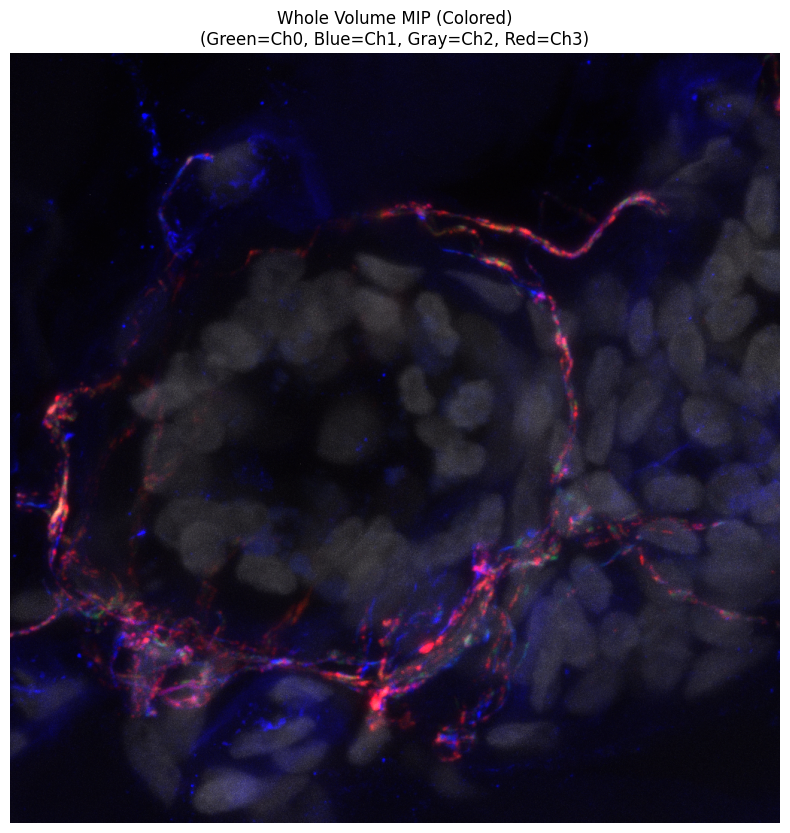

Saved whole volume view to images/whole_volume_colored.png


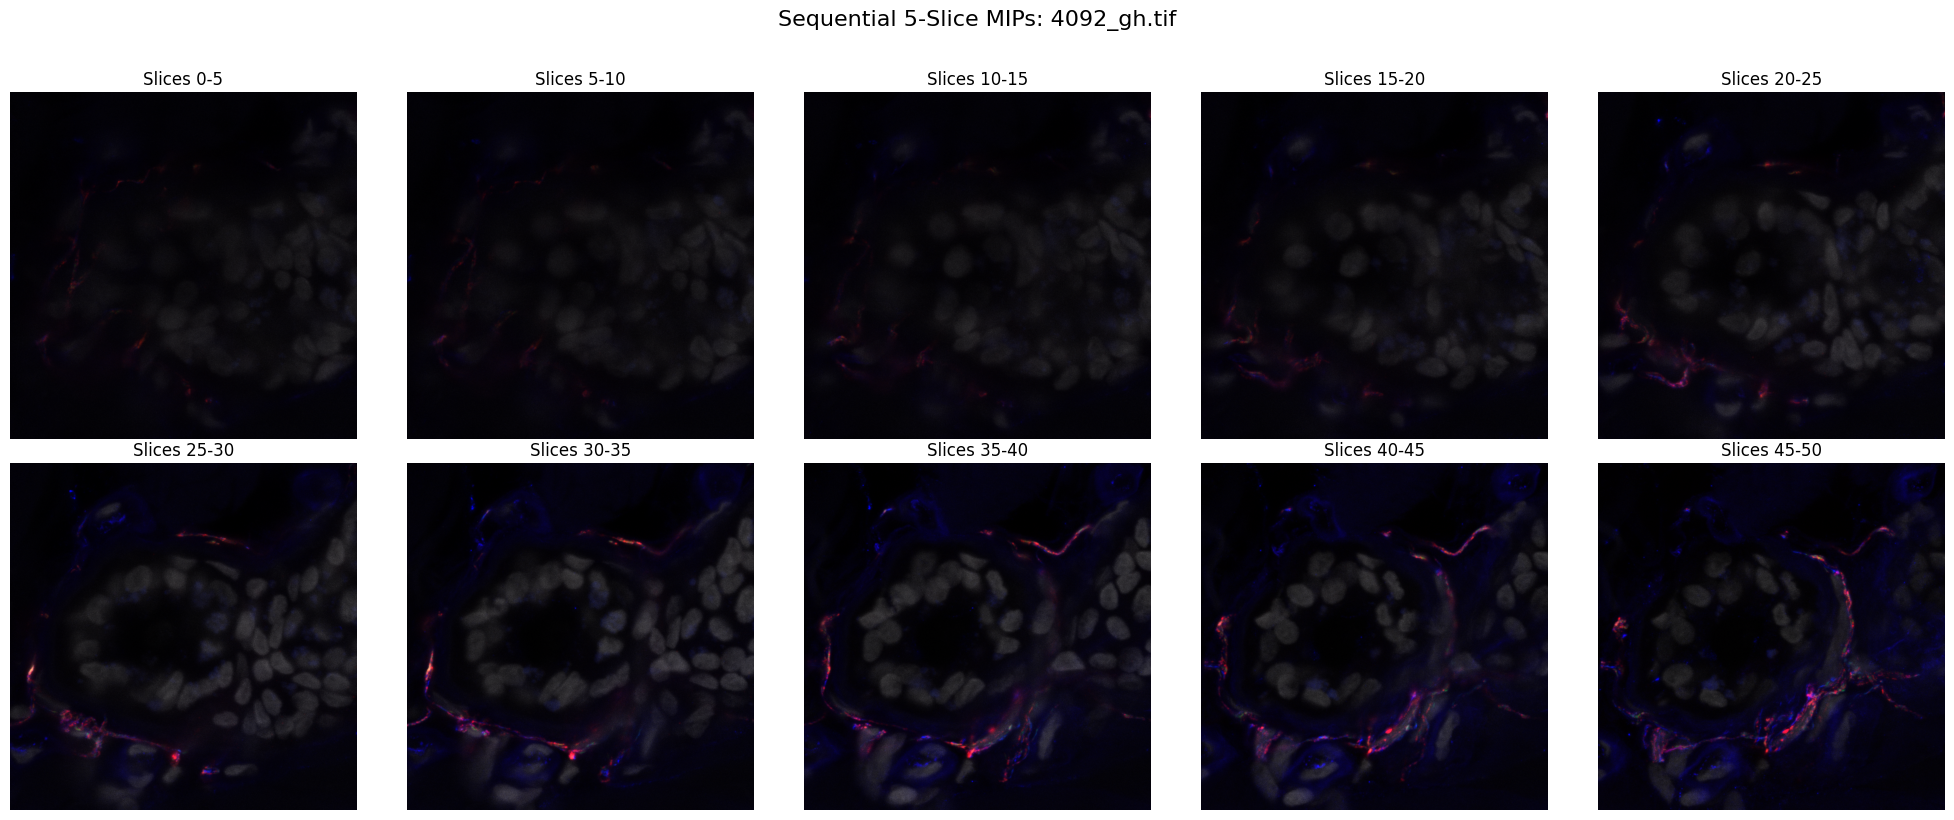

Saved slab grid to images/slab_mips_colored.png


In [20]:
import tifffile
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# 1. Load and Prepare Data
tif_path = Path("../data/4092_gh.tif")
vol_raw = tifffile.imread(tif_path)

# Normalize
vol_norm = vol_raw.astype(np.float32)
if vol_norm.max() > 1.0:
    if vol_raw.dtype == np.uint16:
        vol_norm /= 65535.0
    elif vol_raw.dtype == np.uint8:
        vol_norm /= 255.0
    else:
        vol_norm /= vol_norm.max()

# Ensure (C, Z, H, W)
if vol_norm.ndim == 3 and vol_norm.shape[0] % 4 == 0:
    new_z = vol_norm.shape[0] // 4
    vol_4d = vol_norm.reshape(4, new_z, vol_norm.shape[1], vol_norm.shape[2])
elif vol_norm.ndim == 4:
    if vol_norm.shape[0] == 4:
        vol_4d = vol_norm
    elif vol_norm.shape[1] == 4:
        vol_4d = np.moveaxis(vol_norm, 1, 0)
    else:
        vol_4d = vol_norm
else:
    # Fallback for safety
    vol_4d = vol_norm[np.newaxis, ...]

print(f"Data shape: {vol_4d.shape}")

# 2. Define Coloring Function
def get_colored_mip(chunk_4d):
    """
    Generates a colored MIP from a (C, Z, H, W) chunk.
    Mapping:
    Ch0 (Green) -> G
    Ch1 (Blue)  -> B
    Ch2 (Gray)  -> R, G, B
    Ch3 (Red)   -> R
    """
    # MIP along Z (axis 1)
    mip = chunk_4d.max(axis=1) # (C, H, W)
    
    C, H, W = mip.shape
    rgb = np.zeros((H, W, 3), dtype=np.float32)
    
    # Add Gray (Ch2) to all channels first
    if C > 2:
        gray = mip[2]
        rgb[..., 0] += gray
        rgb[..., 1] += gray
        rgb[..., 2] += gray
        
    # Add Green (Ch0) to G
    if C > 0:
        rgb[..., 1] += mip[0]
        
    # Add Blue (Ch1) to B
    if C > 1:
        rgb[..., 2] += mip[1]
        
    # Add Red (Ch3) to R
    if C > 3:
        rgb[..., 0] += mip[3]
        
    return np.clip(rgb, 0, 1)

# 3. Generate Image 1: Whole Volume Representation
img_whole = get_colored_mip(vol_4d)

plt.figure(figsize=(10, 10))
plt.imshow(img_whole)
plt.title("Whole Volume MIP (Colored)\n(Green=Ch0, Blue=Ch1, Gray=Ch2, Red=Ch3)")
plt.axis('off')
save_path_whole = Path("images/whole_volume_colored.png")
plt.savefig(save_path_whole, dpi=200, bbox_inches='tight')
plt.show()
print(f"Saved whole volume view to {save_path_whole}")

# 4. Generate Image 2: Grid of 5-slice slabs
Z_dim = vol_4d.shape[1]
slab_size = 5
n_slabs = int(np.ceil(Z_dim / slab_size))

cols = 5
rows = int(np.ceil(n_slabs / cols))

fig, axes = plt.subplots(rows, cols, figsize=(20, 4 * rows))
axes = axes.flatten()

for i in range(n_slabs):
    start = i * slab_size
    end = min(start + slab_size, Z_dim)
    
    # Extract slab
    chunk = vol_4d[:, start:end, :, :]
    
    # Generate MIP
    img_slab = get_colored_mip(chunk)
    
    axes[i].imshow(img_slab)
    axes[i].set_title(f"Slices {start}-{end}")
    axes[i].axis('off')

# Hide unused subplots
for j in range(n_slabs, len(axes)):
    axes[j].axis('off')

plt.suptitle(f"Sequential 5-Slice MIPs: {tif_path.name}", fontsize=16, y=1.02)
plt.tight_layout()
save_path_slabs = Path("images/slab_mips_colored.png")
plt.savefig(save_path_slabs, dpi=200, bbox_inches='tight')
plt.show()
print(f"Saved slab grid to {save_path_slabs}")